In [399]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle

In [351]:
#change the url for your own dataset
url = '/content/drive/MyDrive/bike_clean.csv'
df = pd.read_csv(url)

In [352]:
df.head()

,Unnamed: 0,datetime,date,hour,season,holiday,open,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
0,1,2017-12-01 00:00:00,2017-12-01,0,Winter,No Holiday,Yes,254,-5.2,37,2.2,20000,-17.6,0.0,0.0,0
1,2,2017-12-01 01:00:00,2017-12-01,1,Winter,No Holiday,Yes,204,-5.5,38,0.8,20000,-17.6,0.0,0.0,0
2,3,2017-12-01 02:00:00,2017-12-01,2,Winter,No Holiday,Yes,173,-6.0,39,1.0,20000,-17.7,0.0,0.0,0
3,4,2017-12-01 03:00:00,2017-12-01,3,Winter,No Holiday,Yes,107,-6.2,40,0.9,20000,-17.6,0.0,0.0,0
4,5,2017-12-01 04:00:00,2017-12-01,4,Winter,No Holiday,Yes,78,-6.0,36,2.3,20000,-18.6,0.0,0.0,0


In [353]:
df.columns

Index(['Unnamed: 0', 'datetime', 'date', 'hour', 'season', 'holiday', 'open',
       'rent_count', 'temperature', 'humidity', 'wind_speed', 'visibility',
       'dewpoint_temp', 'solar_radiation', 'rainfall', 'snowfall'],
      dtype='object')

In [354]:
# I kept the month and day to see if there might be correlations to the rent count
df['month'] = pd.DatetimeIndex(df['datetime']).month
df['day'] = pd.DatetimeIndex(df['datetime']).day
df['weekday'] = pd.DatetimeIndex(df['datetime']).dayofweek

In [355]:
# dropping the date columns
df.drop(columns = ["Unnamed: 0", "datetime", "date"], inplace = True)

In [356]:
df.describe()

,hour,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall,month,day,weekday
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,11.500000,704.602055,12.882922,58.226256,1.724909,14368.257991,4.073813,0.569111,0.148687,0.750685,6.526027,15.720548,3.002740
std,6.922582,644.997468,11.944825,20.362413,1.036300,6082.987120,13.060369,0.868746,1.128193,4.367462,3.448048,8.796749,1.998056
min,0.000000,0.000000,-17.800000,0.000000,0.000000,270.000000,-30.600000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,5.750000,191.000000,3.500000,42.000000,0.900000,9400.000000,-4.700000,0.000000,0.000000,0.000000,4.000000,8.000000,1.000000
50%,11.500000,504.500000,13.700000,57.000000,1.500000,16980.000000,5.100000,0.010000,0.000000,0.000000,7.000000,16.000000,3.000000
75%,17.250000,1065.250000,22.500000,74.000000,2.300000,20000.000000,14.800000,0.930000,0.000000,0.000000,10.000000,23.000000,5.000000
max,23.000000,3556.000000,39.400000,98.000000,7.400000,20000.000000,27.200000,3.520000,35.000000,88.000000,12.000000,31.000000,6.000000


In [357]:
df.head()

,hour,season,holiday,open,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall,month,day,weekday
0,0,Winter,No Holiday,Yes,254,-5.2,37,2.2,20000,-17.6,0.0,0.0,0,12,1,4
1,1,Winter,No Holiday,Yes,204,-5.5,38,0.8,20000,-17.6,0.0,0.0,0,12,1,4
2,2,Winter,No Holiday,Yes,173,-6.0,39,1.0,20000,-17.7,0.0,0.0,0,12,1,4
3,3,Winter,No Holiday,Yes,107,-6.2,40,0.9,20000,-17.6,0.0,0.0,0,12,1,4
4,4,Winter,No Holiday,Yes,78,-6.0,36,2.3,20000,-18.6,0.0,0.0,0,12,1,4


#Scaling the data

In [358]:
colnames = list(df.columns)
columns_to_scale = colnames[5:13] #scaling specific columns changes the order of the columns so I had to label them back
columns_untouched = colnames[:5] + colnames[13:]

features = df[colnames]
ct = ColumnTransformer([
            ('scaled_df', StandardScaler(), columns_to_scale)
                    ], remainder = 'passthrough')

scaled_df = pd.DataFrame(ct.fit_transform(features))
scaled_df.columns = columns_to_scale + columns_untouched

# Decision Tree (Random Forest)

## Splitting the data

In [359]:
# X is the variables and y is the response
X = scaled_df.iloc[:, scaled_df.columns != "rent_count"]
y = scaled_df.iloc[:, 12]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)
X_column_names = X_train.columns # just keeping track of the column names

In [361]:
#vectorising the data for the model to work
categorical_encoder = OneHotEncoder(handle_unknown = "ignore")
ct = ColumnTransformer(
    transformers = [("categorical", categorical_encoder, list(range(8,15)))]
    , remainder = 'passthrough'
)
X_train = ct.fit_transform(X_train)
X_test = ct.fit_transform(X_test)

## Training the model

In [362]:
model = RandomForestRegressor(random_state = 42)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

##Checking the error between prediction and test value

In [369]:
y_pred = model.predict(X_test)

In [372]:
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R Squared Score:', (metrics.r2_score(y_test, y_pred)))

Explained Variance Score: 0.8903919648869464
Mean Squared Error: 44945.08028207762
R Squared Score: 0.8903217047174007


##Finding the important features

In [389]:
#sorting them
sorted_features = []
for feature, importance in zip(X.columns, model.feature_importances_):
    sorted_features.append((feature, importance))
sorted_features.sort(key = lambda x: x[1], reverse = True)

In [390]:
sorted_features

[('hour', 0.019483172047932845),
 ('temperature', 0.005944168102267746),
 ('dewpoint_temp', 0.00521316650697633),
 ('solar_radiation', 0.004317792346613977),
 ('humidity', 0.0034692559919782674),
 ('snowfall', 0.0029435263982009498),
 ('visibility', 0.002482501289439264),
 ('holiday', 0.0024687803649073247),
 ('wind_speed', 0.002044960559499399),
 ('rainfall', 0.0014936041476304026),
 ('season', 0.0009350121418399237),
 ('open', 0.0008796406728789732),
 ('weekday', 0.0002694971105251361),
 ('month', 0.00023755922798162802),
 ('day', 0.00019178479528295735)]

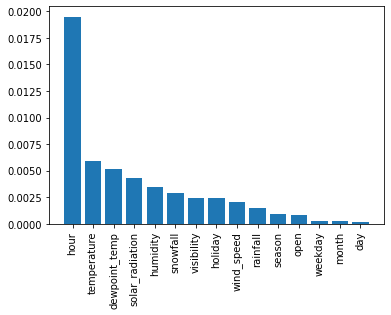

In [397]:
plt.bar([x[0] for x in sorted_features], [y[1] for y in sorted_features])
plt.xticks(rotation='vertical')
plt.show()

#Saving / Loading the model

In [401]:
pkl_filename = "pickle_model.pkl"
file_directory = 'Add the path of your google drive folder'

# Save to file in the current working directory
with open(file_directory + pkl_filename, 'wb') as file:
    #pickle.dump(model, file)

# Load from file
with open(file_directory + pkl_filename, 'rb') as file:
    #pickle_model = pickle.load(file)